**Loading Libraries**

In [11]:
library(diversedata) 
library(tidyverse)  # Loads dplyr, tidyr, stringr, ggplot2, etc.
library(infer)      # For chi-square test
library(dbscan)     # For clustering
library(leaflet)    # For interactive maps
library(treemapify) # For creating treemaps


# 1 Data Cleaning & Processing



To ensure the quality and consistency of the data set, several pre-processing steps were done:

-   **Removed records with missing geographic coordinates**: These records were excluded since latitude and longitude are crucial for spatial mapping and regional distribution analysis.

-   **Standardized the format of region names**: Region names were converted to title case to ensure consistent grouping and filtering.

-   **Converted field types**: The `Industry Sector` column was converted to a factor for categorical analysis, and `Year Formed` was converted to integer to allow for chronological trends and filtering.


In [12]:
# Load and clean the data
indigenousbiz_data <- bcindigenousbiz |>
  filter(!is.na(latitude) & !is.na(longitude)) |>
  mutate(
    region = str_to_title(region),
    industry_sector = as_factor(industry_sector),
    year_formed = as.integer(year_formed)
  )

# Preview cleaned data
indigenousbiz_data |> 
  head()

business_name,city,latitude,longitude,region,type,industry_sector,year_formed,number_of_employees
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>
Ellipsis Energy Inc,Moberly Lake,55.81937,-121.8346,Northeast,Private Company,"Mining, quarrying, and oil and gas extraction",2012,5 to 9
Indigenous Community Development & Prosperity (ICDPRO),Enderby,50.55150,-119.1335,Thompson / Okanagan,Private Company,Other services (except public administration),2020,1 to 4
Formline Construction Ltd.,Burnaby,49.26605,123.0058,Lower Mainland / Southwest,Private Company,Construction,2021,1 to 4
Quilakwa Investments Ltd.,Enderby,50.53751,-119.1420,Thompson / Okanagan,Community Owned Company,Accommodation and food services,1984,20 to 49
Quilakwa Esso,Enderby,50.53751,-119.1420,Thompson / Okanagan,Community Owned Company,Retail trade,1984,10 to 19
Quilakwa RV Park,Enderby,50.55150,-119.1335,Thompson / Okanagan,NA,Accommodation and food services,1984,1 to 4



# 2 Exploratory Data Analysis (EDA)

**Business count by Region**

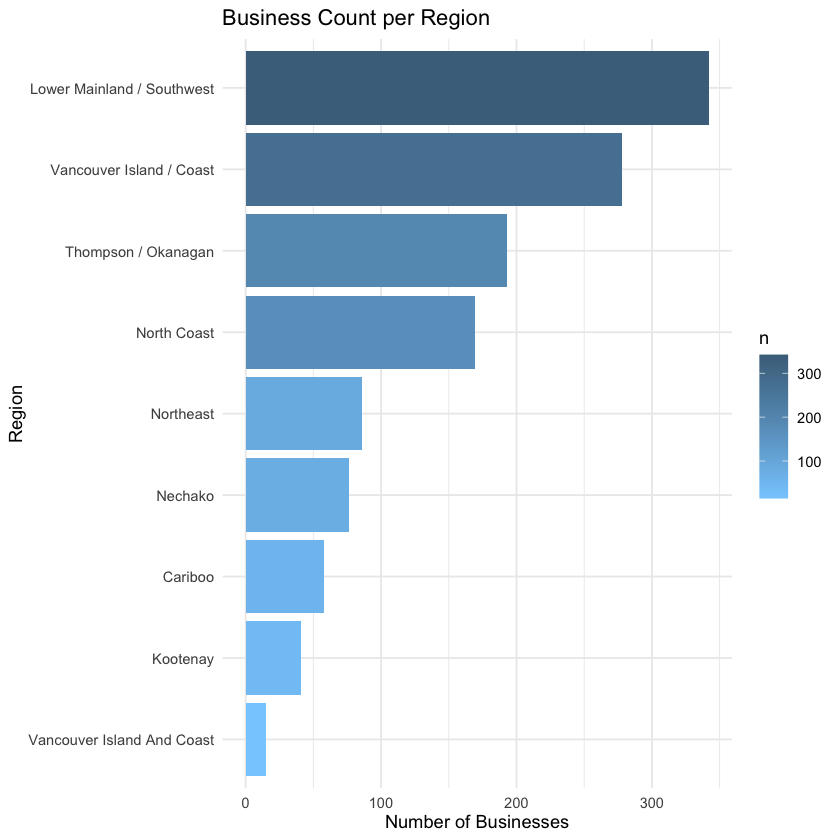

In [14]:

# Business count by region with tidyverse style
indigenousbiz_data |>
  count(region, sort = TRUE) |>
  ggplot(aes(
    x = fct_reorder(region, n),  # Use forcats for reordering
    y = n,
    fill = n
  )) +
  geom_col() +
  coord_flip() +
  scale_fill_gradient(
    low = "skyblue1",
    high = "skyblue4"
  ) +
  labs(
    title = "Business Count per Region",
    x = "Region",
    y = "Number of Businesses"
  ) +
  theme_minimal()


**Mapping Businesses**

In [15]:
# Create leaflet map
indigenousbiz_data |>
  leaflet() |>
  addTiles() |>
  setView(lng = -125, lat = 54, zoom = 4.6) |>
  addCircleMarkers(
    lng = ~longitude,
    lat = ~latitude,
    label = ~business_name,
    radius = 3,
    color = "#1E90FF",
    stroke = FALSE,
    fillOpacity = 0.7
  )


HTML widgets cannot be represented in plain text (need html)

**Industry Analysis**

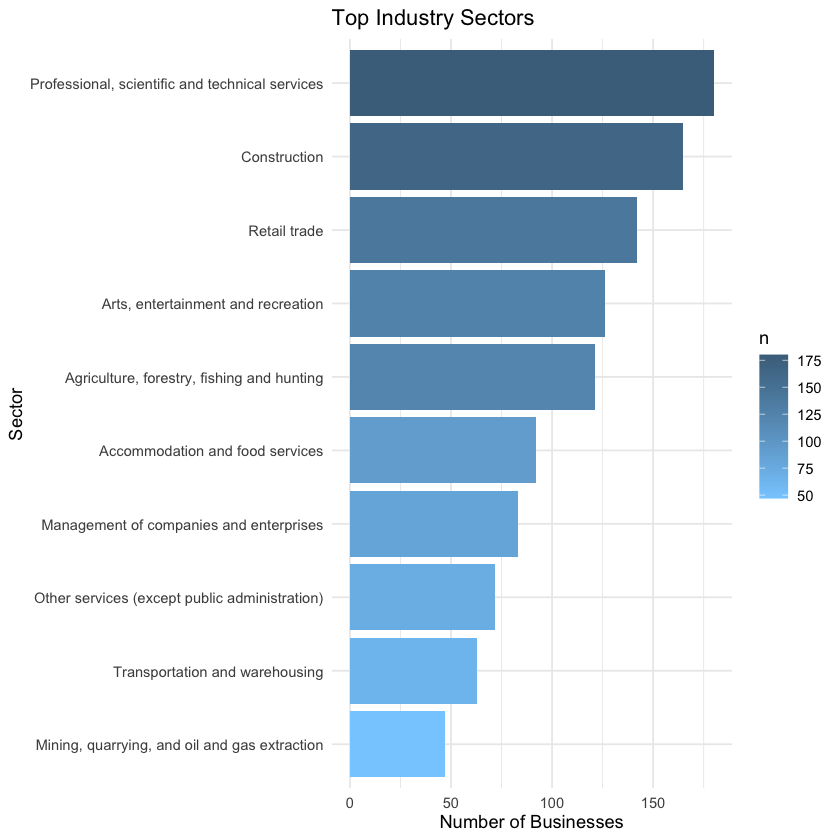

In [17]:
# Plot top 10 industry sectors
indigenousbiz_data |>
  count(industry_sector, sort = TRUE) |>
  slice_max(n, n = 10) |>
  ggplot(aes(
    x = fct_reorder(industry_sector, n),
    y = n,
    fill = n
  )) +
  geom_col() +
  scale_fill_gradient(low = "skyblue1", high = "skyblue4") +
  coord_flip() +
  labs(
    title = "Top Industry Sectors",
    x = "Sector",
    y = "Number of Businesses"
  ) +
  theme_minimal()


# 3 Chi-Squared Test of Independence

To better understand the relationship between Indigenous business locations and their characteristics, we test whether `type` (ownership type) is independent of `region` using a Chi-square test.

**Hypotheses**

-   Null Hypothesis (H₀): Business ownership type and region are independent. That is, the distribution of ownership types is the same across all regions.

-   Alternative Hypothesis (Ha): Business ownership type and region are dependent. That is, the distribution of ownership types differs by region.

**Chi-squared Assumption Check**

-   Data in Frequency Form: The data used in this test are raw counts of business records, not percentages or proportions.

-   Categorical Variables: Both variables under study, type and region are categorical and represent discrete groups.

-   Independence of Observations: Each row in the data set corresponds to a unique business. There is no duplication, satisfying the assumption of independence.

-   Expected Count: The Chi-square test expects that all expected cell frequencies are ≥ 5. In our case this assumption is violated.



In [20]:

## Assumptions check
# Step 1: Chi-Square Assumption Check
type_region_table <- table(indigenousbiz_data$type, indigenousbiz_data$region)
chisq_result <- chisq.test(type_region_table)


Warning message in chisq.test(type_region_table):
“Chi-squared approximation may be incorrect”


In [21]:
expected_counts <- chisq_result$expected

min_expected <- min(expected_counts)

cat("Chi-Square Assumptions:\n")


Chi-Square Assumptions:


In [22]:
cat("- Minimum expected count:", round(min_expected, 2), "\n")

- Minimum expected count: 0.01 


In [24]:
if (min_expected >= 5) {
  cat("Chi-squared assumptions met. Proceeding with standard test.\n")
  print(chisq_result)
} else {
  cat("Assumptions violated. Proceeding with simulation-based Chi-squared test.\n\n")
}

Assumptions violated. Proceeding with simulation-based Chi-squared test.



**Simulation-based Chi-Square Test with `infer`**

Since the assumption regarding minimum expected cell counts was violated with at least one expected frequency falling below the threshold of 5. The Chi-squared test may yield inaccurate results. To overcome this, we use a simulation-based Chi-squared test via the infer package. This method generates a null distribution by permuting the data under the assumption of independence.

The simulation-based tests still require some assumptions to hold:

- The data must represent independent observations.

-   The variables must be categorical.

-   The permutations assume that under the null hypothesis, the distribution of values across categories is exchangeable.



In [ ]:
# Generate null distribution
null_distribution <- indigenousbiz_data |>
  specify(type ~ region) |>
  hypothesize(null = "independence") |>
  generate(reps = 1000, type = "permute") |>
  calculate(stat = "Chisq")


Warning message:
“Removed 136 rows containing missing values.”


In [ ]:
# Observed statistic
observed_stat <- indigenousbiz_data |>
  specify(type ~ region) |>
  hypothesize(null = "independence") |>
  calculate(stat = "Chisq")


Warning message:
“Removed 136 rows containing missing values.”


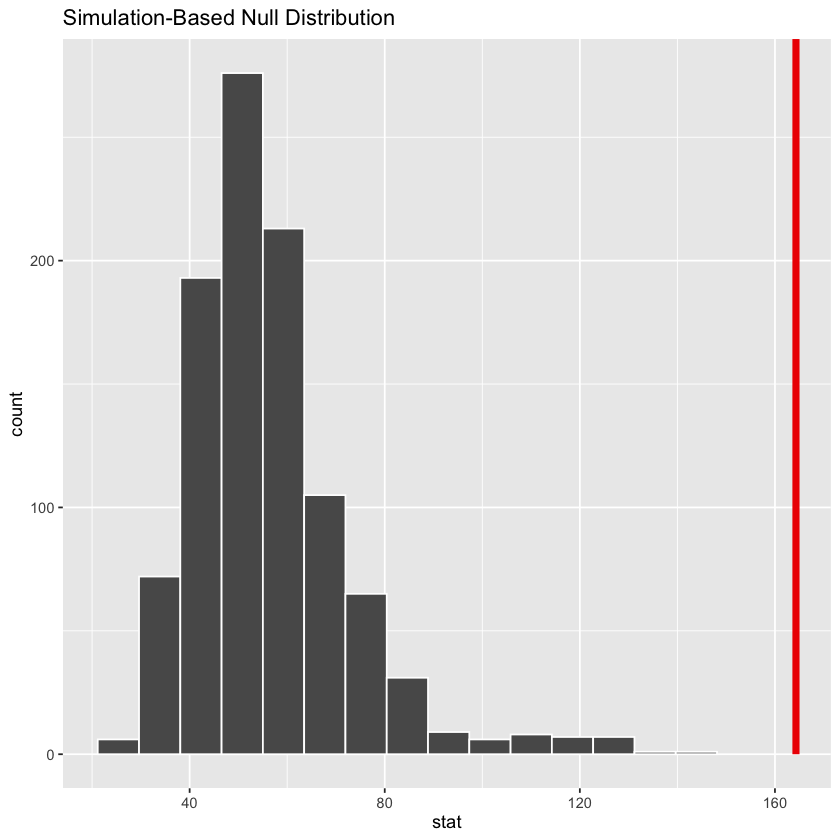

In [28]:
# Plot permutation distribution
null_distribution |>
  visualize() +
  shade_p_value(obs_stat = observed_stat, direction = "greater")


In [29]:
# Compute p-value
p_val <- null_distribution |>
  get_p_value(obs_stat = observed_stat, direction = "greater")

cat("Simulation-based p-value:", round(p_val$p_value, 4), "\n")

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation
based on the number of `reps` chosen in the `generate()` step.
ℹ See `get_p_value()` (`?infer::get_p_value()`) for more information.”


Simulation-based p-value: 0 


**Inference**

To assess whether there is an association between business type and region, we conducted a simulation-based chi-squared test using 1,000 permutations. The null distribution of test statistics generated under the assumption of independence shows that our observed statistic lies far in the tail of the distribution. This suggests that such an extreme result would be highly unlikely if business type and region were truly independent. Therefore, we reject the null hypothesis and conclude that business type and region are statistically dependent.


# 4 Spatial Clustering of Indigenous Businesses using DBSCAN

To explore geographic patterns in Indigenous business, the technique of clustering based on latitude and longitude coordinates was applied. This analysis revealed several spatial clusters of Indigenous businesses across British Columbia. The treemap provided more information on which were the prominent industries in each cluster.



In [32]:
## DBSCAN Clustering and Leaflet Map

coords <- indigenousbiz_data |>
  select(longitude, latitude) |>
  as.matrix()

set.seed(123)
db <- dbscan::dbscan(coords, eps = 1.2, minPts = 8)

indigenousbiz_data <- indigenousbiz_data |>
  mutate(cluster = factor(db$cluster))

pal <- colorFactor(palette = "Set1", domain = indigenousbiz_data$cluster)

cluster_map <- leaflet(data = indigenousbiz_data) |>
  addTiles() |>
  setView(lng = -125, lat = 54, zoom = 4.6) |>
  addCircleMarkers(
    label = ~business_name,
    radius = 3,
    color = ~pal(cluster),
    stroke = FALSE,
    fillOpacity = 0.7
  ) |>
  addLegend(
    position = "bottomright",
    pal = pal,
    values = ~cluster,
    title = "Cluster",
    opacity = 1
  )

cluster_map



Assuming "longitude" and "latitude" are longitude and latitude, respectively



HTML widgets cannot be represented in plain text (need html)

# 5 Treemap of Industry sectors within cluster

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_treemap_text()`).”


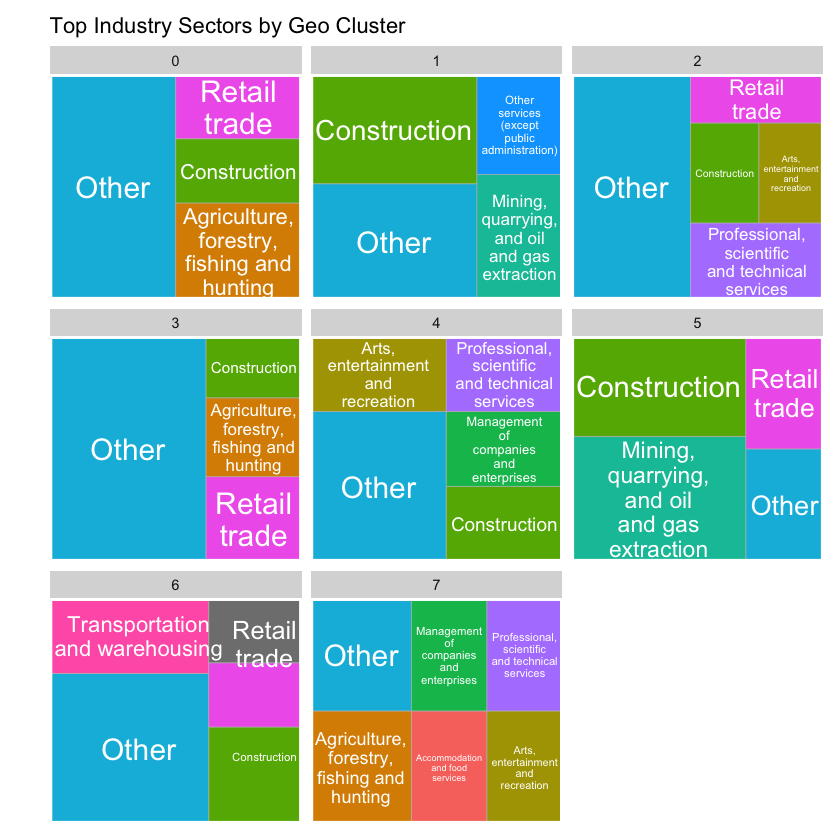

In [33]:
## Industry Counts and Treemap Visualization

industry_cluster_counts <- indigenousbiz_data |>
  count(cluster, industry_sector)

ranked_industries <- industry_cluster_counts |>
  group_by(cluster) |>
  mutate(rank = rank(-n, ties.method = "min")) |>
  ungroup()

top_industries <- ranked_industries |>
  mutate(
    industry_sector = if_else(rank <= 3, as.character(industry_sector), "Other")
  ) |>
  group_by(cluster, industry_sector) |>
  summarise(n = sum(n), .groups = "drop") |>
  mutate(
    cluster = factor(cluster),
    industry_sector = factor(industry_sector)
  )

ggplot(top_industries, aes(area = n, fill = industry_sector,
                           label = industry_sector, subgroup = cluster)) +
  geom_treemap() +
  geom_treemap_subgroup_border(color = "white") +
  geom_treemap_text(colour = "white", place = "centre", reflow = TRUE) +
  facet_wrap(~ cluster) +
  coord_cartesian(clip = "off") +
  theme(
    legend.position = "none",
    plot.margin = margin(t = 10, r = 10, b = 10, l = 30)
  ) +
  labs(
    title = "Top Industry Sectors by Geo Cluster",
    fill = "Industry Sector"
  )



# Discussion

This analysis provides a multi faceted view of Indigenous businesses in British Columbia. The statistical and spatial explorations reveal that both regional context and business structure are deeply intertwined with Indigenous entrepreneurship.

The Chi-square test of independence, supported by simulation-based inference due to assumption violations, reveals a statistically significant association between business ownership type and geographic region. This suggests that certain forms of business organization such as community-owned enterprises or private companies may be more prevalent in specific regions, potentially influenced by local governance structures, access to funding, or historical land use patterns.

The spatial clustering using DBSCAN further enriches this narrative by identifying natural groupings of businesses based on their latitude and longitude coordinates. These clusters likely reflect real-world economic and social hubs within the province. The treemap visualization provides a clear breakdown of dominant industry sectors within each spatial cluster, especially after aggregating less-represented sectors into an 'Other' category for interpretability.

In summary, this analysis highlights how Indigenous business patterns in British Columbia are shaped by both geographic and organizational factors. While insightful, the findings should be interpreted with caution given the cross-sectional nature of the data and sensitivity of the clustering method.